In [The Mean and Slopes](mean_and_slopes), we used a simple but slow way to
find the slope that best predicted one vector of values from another vector of
values.

First we go back to find that slope.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Make plots look a little bit more fancy
plt.style.use('fivethirtyeight')
# Print to 2 decimal places, show tiny values as 0
np.set_printoptions(precision=2, suppress=True)
import pandas as pd

Download the [gender_stats.csv]({{ site.baseurl }}/data/gender_stats.csv) file
to the same directory as this notebook, if you are running on your own computer.

Fetch and process the data:

In [2]:
# Load the data file
gender_data = pd.read_csv('gender_stats.csv')
# Make new data frame with only MMR and FR
just_mmr_fr = gender_data[['mat_mort_ratio', 'fert_rate']]
# Drop the NaN values, and make into arrays.
clean_mmr_fr = just_mmr_fr.dropna()
mmr = np.array(clean_mmr_fr['mat_mort_ratio'])
fert = np.array(clean_mmr_fr['fert_rate'])

Our criterion is the sum of squared error:

In [3]:
def sos_error(slope):
    fitted = fert * slope  # 'fert' comes from the top level
    error = mmr - fitted     # 'mmr' comes from the top level
    return np.sum(error ** 2)

We found the best slope by trying a very large number of slopes, and recording, for each slope, the sum of squared error.  We chose the slope from the slopes that we tried, that gave us the lowest sum of squared error.

In [4]:
# Slopes to try
some_slopes = np.arange(50, 110, 0.1)
n_slopes = len(some_slopes)
# Try all these slopes, calculate and record sum of squared error
sos_errors = np.zeros(n_slopes)
for i in np.arange(n_slopes):
    slope = some_slopes[i]
    sos_errors[i] = sos_error(slope)
# The slope minimizing the sum of squared error
best_slope = some_slopes[np.argmin(sos_errors)]
best_slope

77.8000000000004

At the end, of [the mean and slopes](mean_and_slopes) notebook, we saw that
a function in Scipy called `minimize` can do this work for us, relatively
quickly.

In [5]:
from scipy.optimize import minimize
minimize(sos_error, 100)

      fun: 5901406.206272444
 hess_inv: array([[0.]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([77.84])

What we are doing, with our slow dumb technique, and with the `minimize`
function, is something called [mathematical
optimization](https://en.wikipedia.org/wiki/Mathematical_optimization).  We
use *optimization* when we have some *function* that takes one or more
*parameters*.  We want to chose, or *optimize* the parameters to give us some
desired output from the function. 

In our case our *function* is the sum of squared error, `sos_error`.  The *parameter* is the slope.  We are trying to find the value for the parameter that *minimizes* the result of calling the function `sos_error`.

One way of doing this minimization, is the slow dumb way.  We just try a huge number of values for the parameter (the slope), and chose the value that gives us the lowest output value (the sum of squared error).

This is such a common problem, that there has been an enormous amount of theoretical and practical work on building algorithms to make process of searching for the minimum value more efficient.

This notebook is to give you an idea of how you might do this, and therefore, the kind of things that `minimize` can do, to search quickly for the best parameter.

Let's look again at the shape of the curve relating the slope to the sum of squared error:

Text(0.5, 1.0, 'SSE as a function of slope')

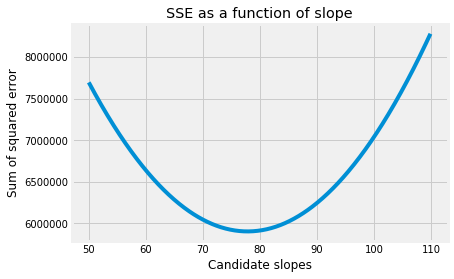

In [6]:
plt.plot(some_slopes, sos_errors)
plt.xlabel('Candidate slopes')
plt.ylabel('Sum of squared error')
plt.title('SSE as a function of slope')

This is the *function* we are trying minimize.

We want to avoid trying every possible value for the slope.

So, we are going to start with one value for the slope, say 100, then see if there is a good way to chose the next value to try.

Looking at the graph, we see that, when the slope is far away from the minimum, the sum of squared error (on the y axis) changes very quickly as the slope changes.  That is, the function has a steep *gradient*.

Maybe we could check what the gradient is, at our starting value of 100, by calculating the sum of squares (y) value, and then calculating the sum of squares (y) value when we increase the slope by a tiny amount.  This is the change in y for a very small change in x.  We divide the change in y by the change in x, to get the gradient:

In [7]:
def sos_error_gradient(x, dx=0.0001):
    # Gradient of the sos_error at this value of x
    # sos_error at this x value.
    sos_0 = sos_error(x)
    # sos_error a tiny bit to the right on the x axis.
    sos_1 = sos_error(x + dx)
    # gradient is y difference divided by x difference.
    return (sos_1 - sos_0) / dx

In [8]:
# The y value of the function.
sos_error(100)

7038632.75610837

In [9]:
# The gradient of the function at this point.
sos_error_gradient(100)

102629.55091893673

A large positive gradient means the x value (slope) that we tried is still far to the *right* of the minimum. This might encourage us to try an x value that is well to the left.  We could call this a large step in x, and therefore a large *step size*.

A large negative gradient means the x value (slope) that we tried is still far to the *left* of the minimum.   This might encourage us to try an x value that is well to the right.

As the gradients get small, we want to take smaller steps, so we don't miss the minimum.

The general idea then, is to chose our step sizes in proportion to the gradient of the function.

This is the optimization technique known as [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent).

Here it is in action, using code modified from the Wikipedia page above.

We try new x (slope) values by moving quickly down the gradient when the gradient is steep, and slowly when the gradient it shallow.

In [10]:
next_x = 100 # The algorithm starts at x=100
gamma = 0.0001 # Step size multiplier
precision = 0.00001 # Desired precision of result
max_iters = 1000 # Maximum number of iterations

for i in np.arange(max_iters):
    cur_x = next_x
    gradient = sos_error_gradient(cur_x)
    next_x = cur_x - gamma * gradient
    step_size = abs(next_x - cur_x)
    print('x: {:0.4f}; step size {:0.4f}; gradient {:0.2f}'.format(
        cur_x, step_size, gradient))
    if step_size <= precision:
        # Answer is precise enough, break out of loop.
        break

print("Minimum at", next_x)

x: 100.0000; step size 10.2630; gradient 102629.55
x: 89.7370; step size 5.5103; gradient 55102.78
x: 84.2268; step size 2.9585; gradient 29585.20
x: 81.2682; step size 1.5885; gradient 15884.57
x: 79.6798; step size 0.8529; gradient 8528.58
x: 78.8269; step size 0.4579; gradient 4579.07
x: 78.3690; step size 0.2459; gradient 2458.55
x: 78.1232; step size 0.1320; gradient 1320.02
x: 77.9912; step size 0.0709; gradient 708.73
x: 77.9203; step size 0.0381; gradient 380.52
x: 77.8822; step size 0.0204; gradient 204.31
x: 77.8618; step size 0.0110; gradient 109.69
x: 77.8508; step size 0.0059; gradient 58.90
x: 77.8450; step size 0.0032; gradient 31.62
x: 77.8418; step size 0.0017; gradient 16.98
x: 77.8401; step size 0.0009; gradient 9.12
x: 77.8392; step size 0.0005; gradient 4.89
x: 77.8387; step size 0.0003; gradient 2.63
x: 77.8384; step size 0.0001; gradient 1.41
x: 77.8383; step size 0.0001; gradient 0.76
x: 77.8382; step size 0.0000; gradient 0.41
x: 77.8382; step size 0.0000; grad

As you can see, by doing this, we save ourselves from trying a very large number of other potential x values (slopes), and we focus in on the minimum very quickly.

This is just one method among many for optimizing our search for the minimum
of a function.  Now you know what kind of thing it is doing, we will just let
`miminize` do its job for us:

In [11]:
# Use float to show us the final result in higher precision
result = minimize(sos_error, 100)
float(result.x)

77.83818669386743